<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/training_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a bunch of normalizing flows with `pzflow`.

First we load all the data.
Then we train flows for
1. $p(z_\text{true}|\text{photometry})$
2. $p(z_\text{phot}|\text{photometry})$
3. $p(z_\text{true}|z_\text{phot})$ and $p(z_\text{phot}|z_\text{true})$

In [ ]:
#!pip install --quiet pzflow corner

In [1]:
import jax.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from pzflow import Flow
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling
from functools import partial

### Loading the data

Assuming a fiducial underlying galaxy catalog, we use `OpSim` to generate observed galaxy catalogs under different observing strategies.

In [2]:
!wget https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
!tar -xzf for_malz_and_lanusse.tar.gz
!mv for_malz_and_lanusse dataset

--2021-04-10 19:48:23--  https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.3.208, 172.217.3.176, 172.217.14.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.3.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35901537 (34M) [application/gzip]
Saving to: 'for_malz_and_lanusse.tar.gz'

100%[======================================>] 35,901,537  58.4MB/s   in 0.6s   

2021-04-10 19:48:24 (58.4 MB/s) - 'for_malz_and_lanusse.tar.gz' saved [35901537/35901537]

mv: cannot move 'for_malz_and_lanusse' to 'dataset/for_malz_and_lanusse': File exists


In [3]:
more dataset/readme.txt

runid      OpSim Name                           ugrizy 5sigma depths
1_4_y10    baseline_v1_5_10yrs                  25.86 27.02 26.99 26.42 25.70 24.94
4_38_y10   footprint_stuck_rollingv1_5_10yrs    25.56 26.68 26.62 26.06 25.33 24.61
10_92_y10  ddf_heavy_nexp2_v1_6_10yrs           25.57 26.82 26.84 26.26 25.57 24.82
4_34_y10   footprint_newAv1_5_10yrs             25.75 26.87 26.85 26.29 25.55 24.78
7_61_y10   third_obs_pt60v1_5_10yrs             25.87 27.03 26.99 26.43 25.70 24.93
9_86_y10   barebones_v1_6_10yrs                 26.00 27.13 27.07 26.57 25.78 25.05

test.cat contains the simulated observed apparent magnitudes
0     : identifier
1     : true redshift
2,3   : u, u uncertainty
4,5   : g, g uncertainty
6,7   : r, r uncertainty
8,9   : i, i uncertainty
10,11 : z, z uncertainty
12,13 : y, y uncertainty
14,15 : u-g, u-g uncertainty
16,17 : g-r, g-r uncertainty
18,19 : r-i, r-i uncertainty
20,21 : i-z, i-z uncertainty
22,23 : z-y, z-y uncertainty

zphot.cat contains the photo

In [4]:
# list of available catalogs
available_os = ["run_1_4_y10", "run_4_38_y10", "run_10_92_y10", "run_4_34_y10", "run_7_61_y10", "run_9_86_y10"]
names = [
    "baseline_v1_5_10yrs",
    "footprint_stuck_rollingv1_5_10yrs",
    "ddf_heavy_nexp2_v1_6_10yrs",
    "footprint_newAv1_5_10yrs",
    "third_obs_pt60v1_5_10yrs",
    "barebones_v1_6_10yrs",
]
os_names = dict(zip(available_os, names))
colors = ["k", "#2ca02c", "tomato", "cornflowerblue", "plum", "gold"]
os_colors = dict(zip(available_os, colors))

In [5]:
# column names of the catalogs
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=(
    'ID', 'z_true', 
    'u', 'err_u',
    'g', 'err_g',
    'r', 'err_r',
    'i', 'err_i',
    'z', 'err_z',
    'y', 'err_y',
    'u-g', 'err_u-g',
    'g-r', 'err_g-r',
    'r-i', 'err_r-i',
    'i-z', 'err_i-z',
    'z-y', 'err_z-y',
)

# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

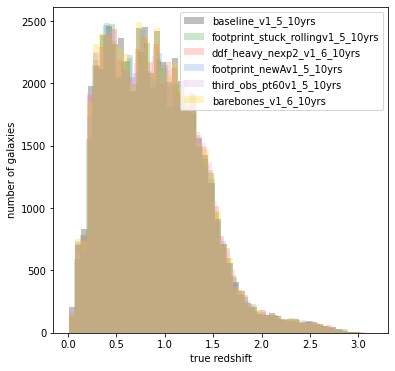

In [6]:
fig = plt.figure(figsize=(6,6))
for os in available_os:
    plt.hist(catalogs[os]["z_true"], bins=50, alpha=0.25, color=os_colors[os],
             label = os_names[os])
    
plt.xlabel("true redshift")
plt.ylabel("number of galaxies")
plt.legend()
plt.show()

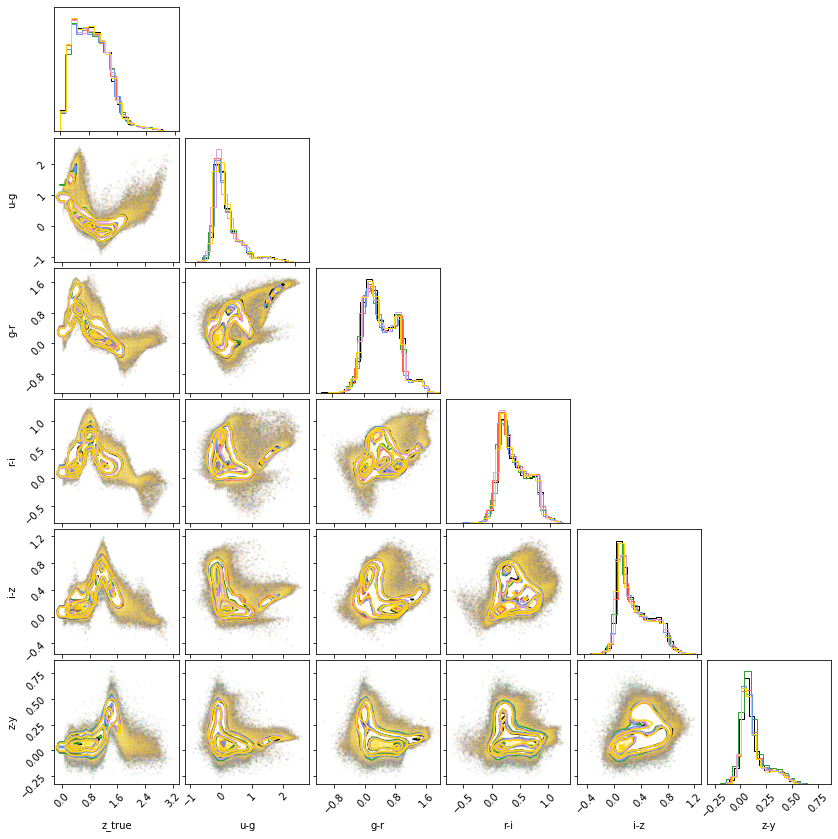

In [7]:
fig = plt.figure(figsize=(12, 12))

labels = ["z_true", "u-g", "g-r", "r-i", "i-z", "z-y"]
for os in available_os:
    corner.corner(catalogs[os][labels], fig=fig, labels=labels, color=os_colors[os])

### Train flows for $p(z_\text{true}|\text{photometry})$

We use `pzflow` to learn $p(z | ugrizy)$

In [8]:
# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I set its domain to (-5, 5)
#     and told it to expect 6 conditions, which will be the r mag and the galaxy colors
bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=6)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform((-5, 5))

# define a condition scaler that will standard scale all of the conditions
# before they are given to the flow for training, sampling, log_prob, etc.
def condition_scaler(data, columns, mean, std):
    scaled_data = data.copy()
    scaled_data[columns] = (scaled_data[columns] - mean) / std
    return scaled_data

# create a dictionary that will hold all the flows
flows = dict()

# create the baseline flows
for os in available_os:
    
    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]
    
    # calculate mean and std of conditions for the condition scaler
    mean = catalogs[os][conditional_columns].mean()
    std = catalogs[os][conditional_columns].std()
    
    # save some info with the flow
    info = {"description": f"Models z_true conditioned on galaxy colors and r mag from os {os}. K=16",
            "condition_scaler": partial(condition_scaler, columns=conditional_columns, mean=mean, std=std)}

    # instantiate and save the flow
    flow = Flow(data_columns = data_columns, 
                conditional_columns = conditional_columns,
                bijector = bijector,
                latent = latent,
                info = info)
    
    flows[os] = flow
 
    
# create the magnitude flows
for os in available_os:
    
    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["u", "g", "r", "i", "z", "y"]
    
    # calculate mean and std of conditions for the condition scaler
    mean = catalogs[os][conditional_columns].mean()
    std = catalogs[os][conditional_columns].std()
    
    # save some info with the flow
    info = {"description": f"Models z_true conditioned on galaxy magnitudes from os {os}. K=16",
            "condition_scaler": partial(condition_scaler, columns=conditional_columns, mean=mean, std=std)}

    # instantiate and save the flow
    flow = Flow(data_columns = data_columns, 
                conditional_columns = conditional_columns,
                bijector = bijector,
                latent = latent,
                info = info)
    
    flows[os + "_mag_trained"] = flow
    

# create flows with different spline resolutions
for K in [2, 8, 32]:
    
    # create a bijector with the correct number of spline knots
    bijector = Chain(
        StandardScaler(np.atleast_1d(1.2), np.atleast_1d(0.32)),
        NeuralSplineCoupling(B=5, n_conditions=6, K=K)
    )
    
    for os in available_os:
    
        # the data column is the one that is sampled and transformed by the flow
        data_columns = ["z_true"]
        # the conditional columns are the columns that the flow is conditioned on
        conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]

        # calculate mean and std of conditions for the condition scaler
        mean = catalogs[os][conditional_columns].mean()
        std = catalogs[os][conditional_columns].std()

        # save some info with the flow
        info = {"description": f"Models z_true conditioned on galaxy colors and r mag from os {os}. K={K}",
                "condition_scaler": partial(condition_scaler, columns=conditional_columns, mean=mean, std=std)}

        # instantiate and save the flow
        flow = Flow(data_columns = data_columns, 
                    conditional_columns = conditional_columns,
                    bijector = bijector,
                    latent = latent,
                    info = info)

        flows[os + f"_K={K}"] = flow

Simple utility function to get the run name out of any of the flow names

In [9]:
def partition_flow_name(fname):
    return "".join(fname.partition("y10")[:-1]), "".join(fname.partition("y10")[-1])

Now let's train each flow

In [10]:
%%time
losses = dict()
for fname in flows:
    os = partition_flow_name(fname)[0]
    print(f"Training flow for {fname}: {os_names[os]}")
    loss = flows[fname].train(flows[fname].info["condition_scaler"](catalogs[os]), epochs=150, verbose=False)
    losses[fname] = loss

Training flow for run_1_4_y10: baseline_v1_5_10yrs
Training flow for run_4_38_y10: footprint_stuck_rollingv1_5_10yrs
Training flow for run_10_92_y10: ddf_heavy_nexp2_v1_6_10yrs
Training flow for run_4_34_y10: footprint_newAv1_5_10yrs
Training flow for run_7_61_y10: third_obs_pt60v1_5_10yrs
Training flow for run_9_86_y10: barebones_v1_6_10yrs
Training flow for run_1_4_y10_mag_trained: baseline_v1_5_10yrs
Training flow for run_4_38_y10_mag_trained: footprint_stuck_rollingv1_5_10yrs
Training flow for run_10_92_y10_mag_trained: ddf_heavy_nexp2_v1_6_10yrs
Training flow for run_4_34_y10_mag_trained: footprint_newAv1_5_10yrs
Training flow for run_7_61_y10_mag_trained: third_obs_pt60v1_5_10yrs
Training flow for run_9_86_y10_mag_trained: barebones_v1_6_10yrs
Training flow for run_1_4_y10_K=2: baseline_v1_5_10yrs
Training flow for run_4_38_y10_K=2: footprint_stuck_rollingv1_5_10yrs
Training flow for run_10_92_y10_K=2: ddf_heavy_nexp2_v1_6_10yrs
Training flow for run_4_34_y10_K=2: footprint_newAv

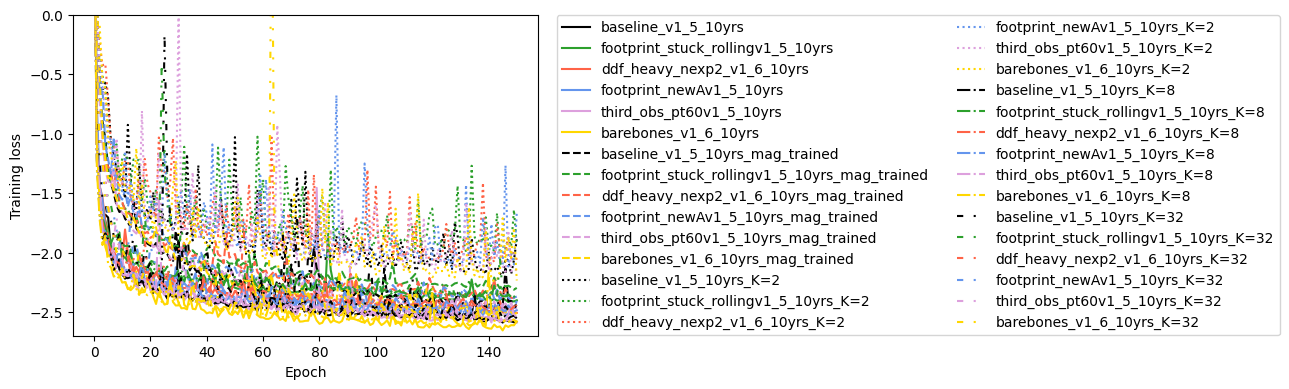

In [11]:
fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)

ls = ["-", "--", ":", "-.", (0, (3, 5, 1, 5, 1, 5))]
for i,fname in enumerate(flows):
    os, extra = partition_flow_name(fname)
    ax.plot(losses[fname], c=os_colors[os], ls=ls[i//len(available_os)], label=os_names[os]+extra)

ax.set(xlabel = "Epoch", ylabel = "Training loss", ylim = (-2.7, 0))
ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, ncol=2)

plt.show()

To calculate log_probs, use `flow.log_prob(flow.info["condition_scaler"](data))` where data is a data frame that has columns for `z_true, r, u-g, g-r, r-i, i-z, z-y` (note that `z_true` is the true redshift, not the true z band magnitude).

In [12]:
for fname in flows:
    file_name = f"trained_flows/flow_for_{fname}.pkl"
    flows[fname].save(file_name)

Now I will show that the value of K doesn't really matter

first a plot for the paper:

In [13]:
K_comp = dict()
for K in [2, 8, 16, 32]:
    if K == 16:
        flow = flows["run_1_4_y10"]
    else:
        flow = flows[f"run_1_4_y10_K={K}"]
        
    sample = flow.sample(conditions=flow.info["condition_scaler"](catalogs["run_1_4_y10"]))
    K_comp[K] = sample

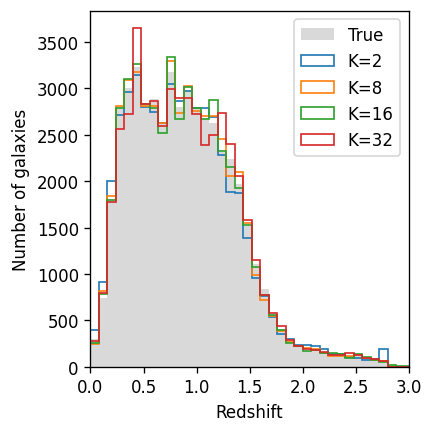

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=120, constrained_layout=True)

nbins = 40
ax.hist(catalogs["run_1_4_y10"].z_true, range=(0, 3.2), bins=nbins, label="True", alpha=0.15, color="k")

for K in [2, 8, 16, 32]:
    ax.hist(K_comp[K].z_true, range=(0, 3.2), bins=nbins, histtype="step", label=f"K={K}")
    
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0,3))
ax.legend()

fig.savefig("K-dependence.pdf")

now let's just plot all of them

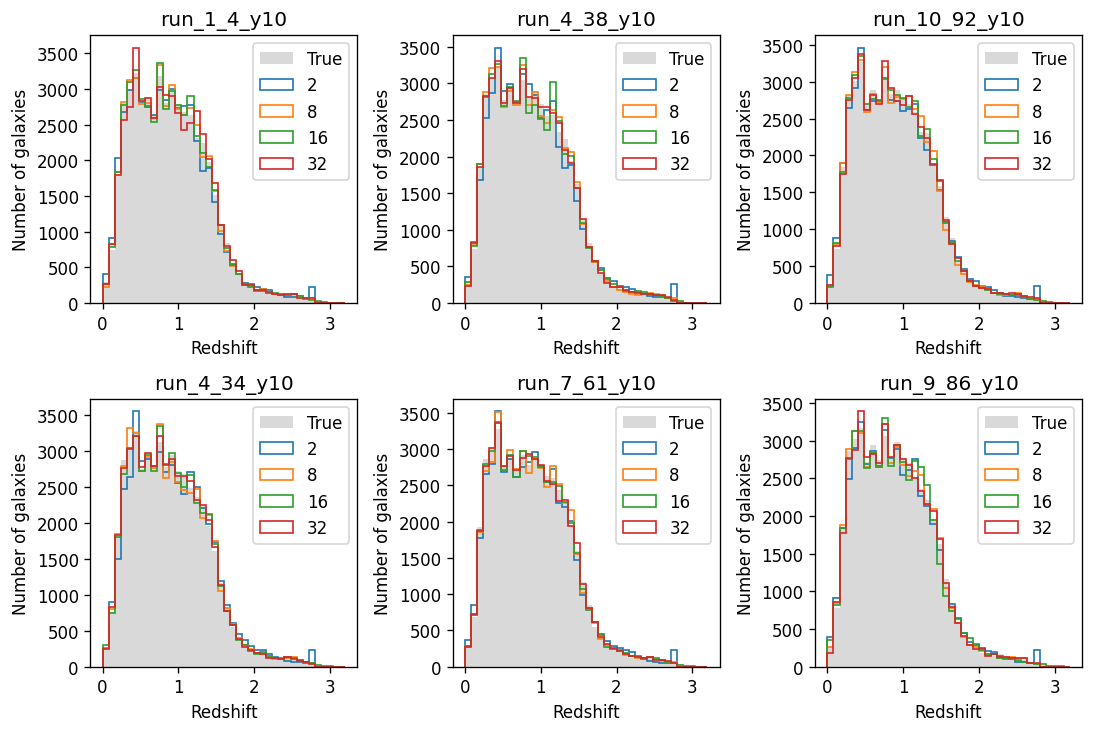

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=120, constrained_layout=True)

nbins = 40

for i, ax in enumerate(axes.flatten()):
    
    os = available_os[i]
    
    ax.set(xlabel="Redshift", ylabel="Number of galaxies", title=os)
    ax.hist(catalogs[os].z_true, range=(0, 3.2), bins=nbins, label="True", alpha=0.15, color="k")
    
    for K in [2, 8, 16, 32]:
        if K == 16:
            flow = flows[os]
        else:
            flow = flows[os + f"_K={K}"]

        sample = flow.sample(conditions=flow.info["condition_scaler"](catalogs[os]), seed=0)
        ax.hist(sample.z_true, range=(0, 3.2), bins=nbins, histtype="step", label=K)

    ax.legend()
    
plt.show()

### Train flow for $p(z_\text{phot}|\text{photometry})$

In [16]:
# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I set its domain to (-5, 5)
#     and told it to expect 6 conditions, which will be the r mag and the galaxy colors
bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=6)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform((-5, 5))

# define a condition scaler that will standard scale all of the conditions
# before they are given to the flow for training, sampling, log_prob, etc.
def condition_scaler(data, columns, mean, std):
    scaled_data = data.copy()
    scaled_data[columns] = (scaled_data[columns] - mean) / std
    return scaled_data

# create a dictionary that will hold all the z_phot flows
zphot_flows = dict()

# create the z_phot flows
for os in available_os:
    
    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_phot"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]
    
    # calculate mean and std of conditions for the condition scaler
    mean = catalogs[os][conditional_columns].mean()
    std = catalogs[os][conditional_columns].std()
    
    # save some info with the flow
    info = {"description": f"Models z_phot conditioned on galaxy colors and r mag from os {os}. K=16",
            "condition_scaler": partial(condition_scaler, columns=conditional_columns, mean=mean, std=std)}

    # instantiate and save the flow
    flow = Flow(data_columns = data_columns, 
                conditional_columns = conditional_columns,
                bijector = bijector,
                latent = latent,
                info = info)
    
    zphot_flows[os + "_zphot|colors"] = flow

In [17]:
%%time
zphot_losses = dict()
for fname in zphot_flows:
    os = partition_flow_name(fname)[0]
    print(f"Training flow for {fname}: {os_names[os]}")
    loss = zphot_flows[fname].train(zphot_flows[fname].info["condition_scaler"](catalogs[os]), epochs=150, verbose=False)
    zphot_losses[fname] = loss

Training flow for run_1_4_y10_zphot|colors: baseline_v1_5_10yrs
Training flow for run_4_38_y10_zphot|colors: footprint_stuck_rollingv1_5_10yrs
Training flow for run_10_92_y10_zphot|colors: ddf_heavy_nexp2_v1_6_10yrs
Training flow for run_4_34_y10_zphot|colors: footprint_newAv1_5_10yrs
Training flow for run_7_61_y10_zphot|colors: third_obs_pt60v1_5_10yrs
Training flow for run_9_86_y10_zphot|colors: barebones_v1_6_10yrs
CPU times: user 4min 49s, sys: 37 s, total: 5min 26s
Wall time: 3min 17s


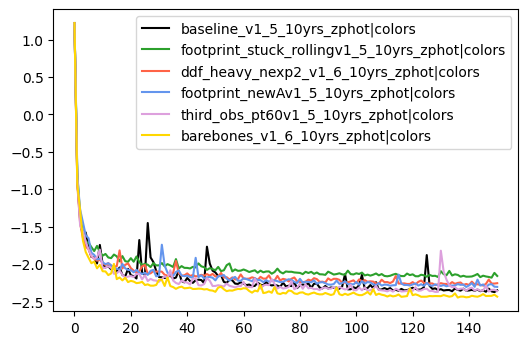

In [18]:
fig, ax = plt.subplots(dpi=100)

for fname in zphot_flows:
    os, extra = partition_flow_name(fname)
    ax.plot(zphot_losses[fname], c=os_colors[os], label=os_names[os]+extra)
    
ax.legend()
plt.show()

In [19]:
for fname in zphot_flows:
    file_name = f"trained_flows/flow_for_{fname}.pkl"
    zphot_flows[fname].save(file_name)

### Train flow for $p(z_\text{true}|z_\text{phot})$ and $p(z_\text{phot}|z_\text{true})$

In [26]:
# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I set its domain to (-5, 5)
#     and told it to expect 1 condition
bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=1)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform((-5, 5))

# define a condition scaler that will standard scale all of the conditions
# before they are given to the flow for training, sampling, log_prob, etc.
def condition_scaler(data, columns, mean, std):
    scaled_data = data.copy()
    scaled_data[columns] = (scaled_data[columns] - mean) / std
    return scaled_data

# create a dictionary that will hold all the z_phot flows
interz_flows = dict()

# create the z_phot|z_true flows
for os in available_os:
    
    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_phot"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["z_true"]
    
    # calculate mean and std of conditions for the condition scaler
    mean = catalogs[os][conditional_columns].mean()
    std = catalogs[os][conditional_columns].std()
    
    # save some info with the flow
    info = {"description": f"Models z_phot conditioned on z_true from os {os}. K=16",
            "condition_scaler": partial(condition_scaler, columns=conditional_columns, mean=mean, std=std)}

    # instantiate and save the flow
    flow = Flow(data_columns = data_columns, 
                conditional_columns = conditional_columns,
                bijector = bijector,
                latent = latent,
                info = info)
    
    interz_flows[os + "_zphot|ztrue"] = flow
    
# create the z_true|z_phot flows
for os in available_os:
    
    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["z_phot"]
    
    # calculate mean and std of conditions for the condition scaler
    mean = catalogs[os][conditional_columns].mean()
    std = catalogs[os][conditional_columns].std()
    
    # save some info with the flow
    info = {"description": f"Models z_true conditioned on z_phot from os {os}. K=16",
            "condition_scaler": partial(condition_scaler, columns=conditional_columns, mean=mean, std=std)}

    # instantiate and save the flow
    flow = Flow(data_columns = data_columns, 
                conditional_columns = conditional_columns,
                bijector = bijector,
                latent = latent,
                info = info)
    
    interz_flows[os + "_ztrue|zphot"] = flow

In [27]:
%%time
interz_losses = dict()
for fname in interz_flows:
    os = partition_flow_name(fname)[0]
    print(f"Training flow for {fname}: {os_names[os]}")
    loss = interz_flows[fname].train(interz_flows[fname].info["condition_scaler"](catalogs[os]), epochs=150, verbose=False)
    interz_losses[fname] = loss

Training flow for run_1_4_y10_zphot|ztrue: baseline_v1_5_10yrs
Training flow for run_4_38_y10_zphot|ztrue: footprint_stuck_rollingv1_5_10yrs
Training flow for run_10_92_y10_zphot|ztrue: ddf_heavy_nexp2_v1_6_10yrs
Training flow for run_4_34_y10_zphot|ztrue: footprint_newAv1_5_10yrs
Training flow for run_7_61_y10_zphot|ztrue: third_obs_pt60v1_5_10yrs
Training flow for run_9_86_y10_zphot|ztrue: barebones_v1_6_10yrs
Training flow for run_1_4_y10_ztrue|zphot: baseline_v1_5_10yrs
Training flow for run_4_38_y10_ztrue|zphot: footprint_stuck_rollingv1_5_10yrs
Training flow for run_10_92_y10_ztrue|zphot: ddf_heavy_nexp2_v1_6_10yrs
Training flow for run_4_34_y10_ztrue|zphot: footprint_newAv1_5_10yrs
Training flow for run_7_61_y10_ztrue|zphot: third_obs_pt60v1_5_10yrs
Training flow for run_9_86_y10_ztrue|zphot: barebones_v1_6_10yrs
CPU times: user 11min 13s, sys: 1min 45s, total: 12min 59s
Wall time: 7min 1s


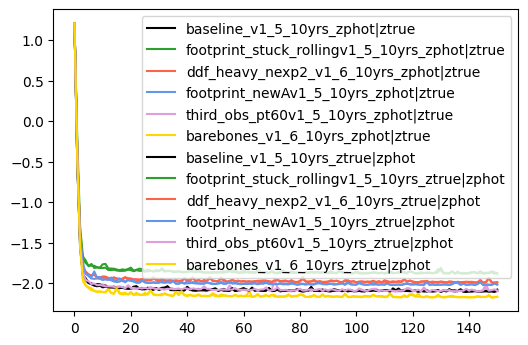

In [28]:
fig, ax = plt.subplots(dpi=100)

for fname in interz_flows:
    os, extra = partition_flow_name(fname)
    ax.plot(interz_losses[fname], c=os_colors[os], label=os_names[os]+extra)
    
ax.legend()
plt.show()

In [29]:
for fname in interz_flows:
    file_name = f"trained_flows/flow_for_{fname}.pkl"
    interz_flows[fname].save(file_name)